[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/justinhou95/market_simulator/blob/main/notebooks/resevoir4.ipynb)

# Signature & Euler 

Consider SDE
$$
dX_t = \sum_{k=1}^{m} B^{k}X_{t}dW^{k}_{t},\quad X_{t}\in \mathbb{R}^{n}, W_{t}\in\mathbb{R}^{m}, B^{k} \in \mathbb{R}^{n\times n}
$$

Signature expansion
$$
X_t = \sum_{d = 0}^{\infty}\sum_{i_{1},\cdots,i_{d} = 1}^{n} \bigg(\int_{0\leq t_{1}\leq\cdots\leq t_{d}\leq t}dW^{i_{1}}_{t_{1}}\cdots dW^{i_{d}}_{t_{d}}\bigg)B^{i_{d}}\cdots B^{i_{1}} X_{0}
$$


Ito vs Stratonovich
$$
X\circ dW = XdW + d[X,W]
$$

In [57]:
%matplotlib inline
import base
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import torch
torch.set_default_dtype(torch.float64)
from importlib import reload
import SDEmethod, Sig_method, Resevoir

In [58]:
# label = 'diagnoal'
# label = 'commute'
# label = 'non-commutative'
label = 'special'
dimensionBM = 2
dimension = 2
B = SDEmethod.get_B(label,dimensionBM,dimension)
length = 100
horizon = 1
dt = horizon / length
initial = np.ones([dimension])  

special
[[[0.1 0.2]
  [0.3 0.4]]

 [[0.4 0.3]
  [0.2 0.1]]]
commutability
[[-0.05 -0.15]
 [ 0.15  0.05]]


In [59]:
mag = int(10000/length)
eq0 = SDEmethod.SDE_linear(horizon,1.0,dimension,dimensionBM,length*mag,B)
time0 = eq0.time
BMpath0 = eq0.BM()
SDEpath0 = eq0.SDE_solver(initial, BMpath0, 'euler')
BMpath = BMpath0[::mag]
SDEpath1 = SDEpath0[::mag]

In [60]:
time0.shape

(10001,)

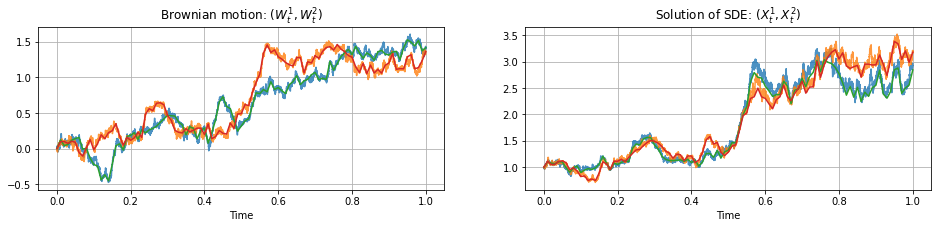

In [61]:
eq = SDEmethod.SDE_linear(horizon,1.0,dimension,dimensionBM,length,B)
time = eq.time
# BMpath = eq.BM()
SDEpath = eq.SDE_solver(initial, BMpath, 'euler')
f,p=plt.subplots(1,2,figsize=(16,3))
p[0].plot(time0,BMpath0,alpha = 0.8)
p[0].plot(time,BMpath)
p[0].title.set_text('Brownian motion: $(W_{t}^{1}, W_{t}^{2})$')
p[0].set_xlabel('Time')
p[0].grid()
# p[0].set_ylabel('common ylabel')

p[1].plot(time0,SDEpath0,alpha = 0.8)
p[1].plot(time,SDEpath)
p[1].title.set_text('Solution of SDE: $(X_{t}^{1}, X_{t}^{2})$ ')
p[1].set_xlabel('Time')
p[1].grid()
plt.show()       

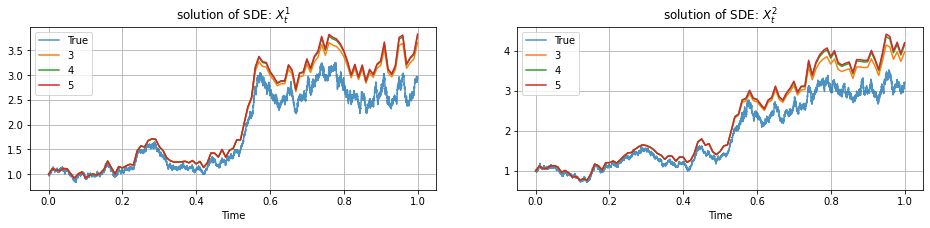

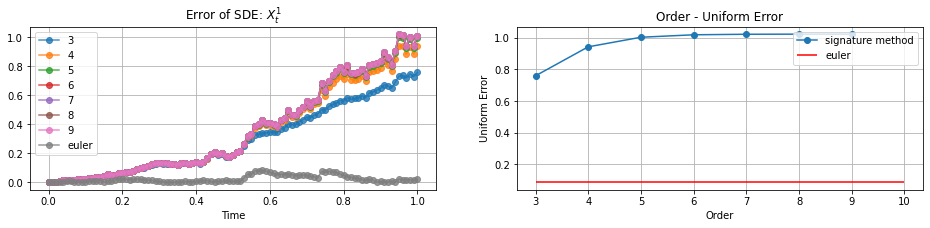

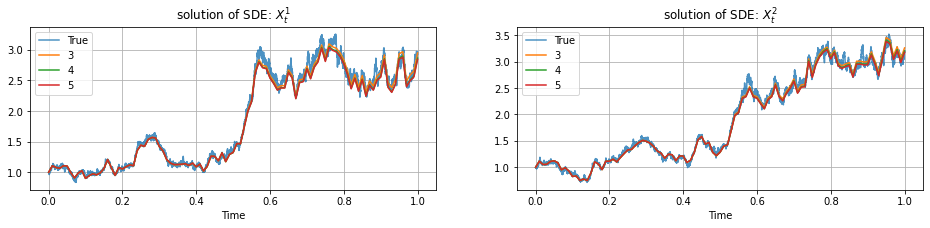

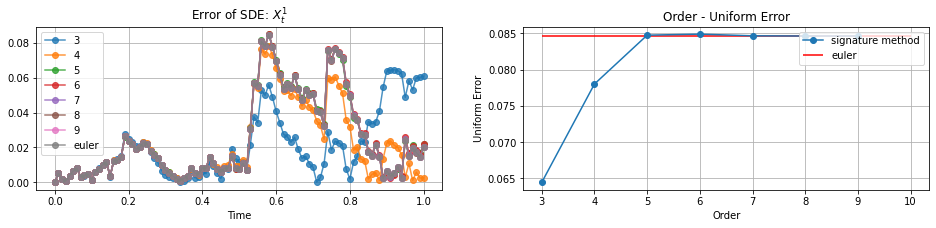

In [62]:
reload(Sig_method)
depth_set = list(range(3, 10))

for growing in [False, True]:
    SDEpath_sig = [Sig_method.SDEfromSig(BMpath,initial,i,B,growing) for i in depth_set]
    f,p=plt.subplots(1,2,figsize=(16,3))
    p[0].plot(time0,SDEpath0[:,0],alpha = 0.8)
    [p[0].plot(time,path[:,0]) for path in SDEpath_sig[:3]]
    p[0].legend(['True'] + depth_set )
    p[0].title.set_text('solution of SDE: $X^{1}_{t}$')
    p[0].set_xlabel('Time')
    p[0].grid()
    
    p[1].plot(time0,SDEpath0[:,1],alpha = 0.8)
    [p[1].plot(time,path[:,1]) for path in SDEpath_sig[:3]]
    p[1].legend(['True'] + depth_set )
    p[1].title.set_text('solution of SDE: $X^{2}_{t}$')
    p[1].set_xlabel('Time')
    p[1].grid()
    plt.show()    

    ERROR = []
    f,p=plt.subplots(1,2,figsize=(16,3))
    for path in SDEpath_sig:
        diff = np.abs(path[:,1] - SDEpath1[:,1])
        p[0].plot(time,diff,'o-',alpha = 0.8)
        ERROR.append(np.max(diff))
    error0 = np.max(np.abs(SDEpath[:,1] - SDEpath1[:,1]))
    p[0].plot(time,np.abs(SDEpath[:,1] - SDEpath1[:,1]),'o-',alpha = 0.8)
    p[0].legend(depth_set + ['euler'])
    p[0].set_xlabel('Time')
    p[0].title.set_text('Error of SDE: $X^{1}_{t}$')
    p[0].set_xlabel('Time')
    p[0].grid()
    
    p[1].plot(depth_set,ERROR,'o-',label = 'signature method')
    p[1].hlines(error0,3,10,'r', label = 'euler')
    p[1].legend(loc = 'upper right')
    p[1].set_xlabel('Order')
    p[1].set_ylabel('Uniform Error')
    p[1].title.set_text('Order - Uniform Error')
    p[1].grid()
    plt.show()

Maybe the design of resevior could utilize the expansive feature of growing signature

# Resevoir Computing
For linear Dynamics
\begin{equation}
    \begin{split}
        X^{(i)}_{t} &= \sum_{m=0}^{\infty}\sum_{i_{1},\cdots,i_{m} = 1}^{d}Sig_{s,t}^{(i_{1},\cdots,i_{m})}\sum_{j=1}^{d}W^{(i_{1},\cdots,i_{m})}_{i,j}X^{(j)}_{s}\\
        &= \sum_{m=0}^{\infty}\sum_{i_{1},\cdots,i_{m} = 1}^{d}\sum_{j=1}^{d}W^{(i_{1},\cdots,i_{m})}_{i,j} \cdot Sig_{s,t}^{(i_{1},\cdots,i_{m})}X^{(j)}_{s}\\
        &= \langle W_{i} , Sig_{s,t} \otimes X_{s} \rangle
    \end{split}
\end{equation}
Training data:

$$
x_{s,t} = Sig_{s,t} \otimes X_{s},\quad y_{s,t} = X_{t}
$$

Note that if we fix all training data with the same 's', then we can decrease the dimension of training data

$$
x_{t} = Sig_{t},\quad y_{t} = X_{t}
$$

Otherwise this is not generally possible by scaling since diagonal matrix is not commutative to any matrix



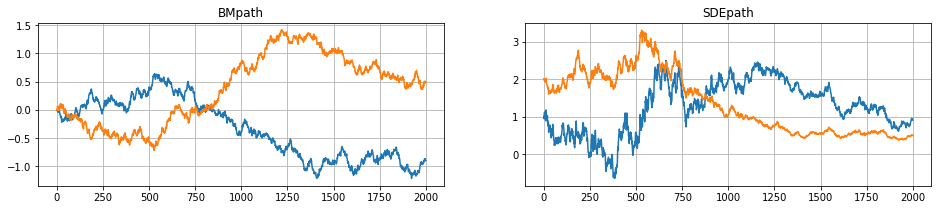

In [63]:
d=2    # dimension of SDE 
dBM = 2 # dimension of BM
horizon = 1.0  # time horizon: T
N_time = 2000  # time discretization
dt = horizon / N_time  # dt 
time = np.arange(N_time+1) * dt # (0, dt, ..., T)
initial_value = np.array([1.0,2.0]) # X0 of the SDE

# name = 'linear'
# SDE = SDEmethod.SDE(horizon,initial_value,d,dBM,SDEmethod.vectorfield2dlinear,N_time) 
name = 'sabr' # define the dynamic (vector field) of SDE
SDE = SDEmethod.SDE(horizon,initial_value,d,dBM,SDEmethod.vectorfield2d,N_time) 
data = SDE.path()
SDE.plot()
data_test = SDE.path()

(1, 1000, 2), (1, 1000, 150), (1, 1000, 14), (1, 1000, 30), (1, 1000, 62), (1, 1000, 126), (1, 1000, 254), (1, 1000, 510), (1, 1000, 1022), 


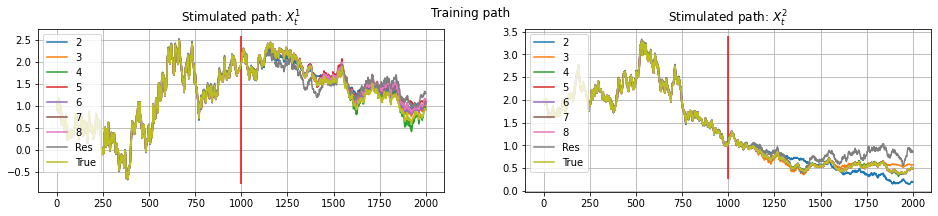

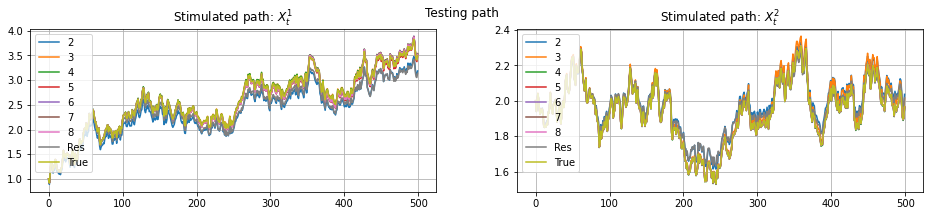

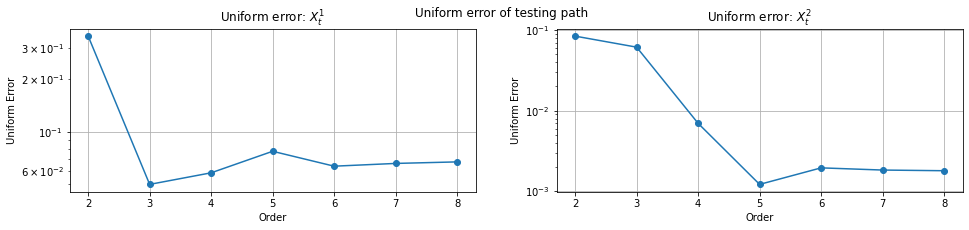

In [64]:
# data = [np.array(t) for t in Res_split.training]
# data_test = [np.array(t) for t in Res_split.generalization]
reload(Resevoir)

R=75  # dimension of Resevoir
depth_learn = list(range(2,9))
Res_split = Resevoir.Resevoir_split(data, depth_learn, R)
Res_split.prepare_all()
trainto = 1000
sublength = 1000
Res_split.prepare_split(sublength, trainto)

# alphas=np.logspace(-10, -8, 3)
alphas = 1e-8
Res_split.train(alphas, verbose = False, fix_intercept = True)
Res_split.plot_all(plot = True, verbose = False)

validto = 500
Res_split.prepare_test(data_test, validto)
Res_split.plot_test(plot = True, verbose = False)

## Compare distributions

In [45]:
import tensorflow as tf
import gpflow
from tqdm.auto import tqdm
from gpsig import kernels
import evaluation
import process_discriminator
# tf.keras.backend.set_floatx('float64')
tf.keras.backend.set_floatx('float32')
reload(Sig_method)

<module 'Sig_method' from '../src\\Sig_method.py'>

In [46]:
n_samples = 100
validto = 50
SDE.timesteps = validto
SDE.dt = SDE.timehorizon/SDE.timesteps
data_test_set = [SDE.path() for i in range(n_samples)]

Res_split.prepare_test_set(validto, data_test_set)
Res_split.test_in_set()

  0%|          | 0/100 [00:00<?, ?it/s]

In [47]:
num_levels = 3
num_lags = 0
kernE = kernels.SignatureKernel(base_kernel = gpflow.kernels.Exponential(), \
                                num_levels = num_levels, order = num_levels, num_lags = num_lags)

In [48]:
log data = True
if not log_data:
    X1_all = tf.convert_to_tensor([[SDE.path()[-1] for i in range(n_samples)] for i in range(10)])
    X2_all = tf.convert_to_tensor([[SDE.path()[-1] for i in range(n_samples)] for i in range(10)])

    TU0 = []
    for i in tqdm(range(10)):
        X1 = X1_all[i]
        X2 = X2_all[i]
        TU0.append(evaluation.Sig_TU2(X1,X2,kernE))

    TU_res = []
    for i in tqdm(range(10)):
        X1 = X1_all[i]
        TU_res.append(evaluation.Sig_TU2(X1,Res_split.X_res,kernE))

    TU_sig = []
    for X_sig_now in Res_split.X_sig:
        TU = []
        for i in tqdm(range(10)):
            X1 = X1_all[i]
            TU.append(evaluation.Sig_TU2(X1,X_sig_now,kernE))
        TU_sig.append(TU)
    TU = np.array([TU0, TU_res] + TU_sig)
    with open('npy/TU_for_ResGenerator_sabr.npy', 'wb') as f:
        np.save(f, TU)
else:
    with open('npy/TU_for_ResGenerator_sabr.npy', 'rb') as f:
        TU = np.load(f)

SyntaxError: invalid syntax (<ipython-input-48-03f88287cbe0>, line 1)

In [ ]:
TU0 = TU[0]
TU_res = TU[1]
TU_sig = TU[2:]

label = ['TU0', 'Res'] + ['Sig' + str(i+1) for i in range(len(TU_sig))] 
plt.figure(figsize = (10,4))
plt.hist(TU.T, bins = 50, density=True, histtype='bar', stacked=True, label = label)
plt.legend()
plt.grid()
plt.xlabel('$T_{U}^{2}$')
plt.title('$T_{U}^{2}$ statistics for different generators')
plt.show()

## Naive Generative model fails

In [14]:
# d=2    # dimension of SDE 
# dBM = 2 # dimension of BM
# horizon = 1.0  # time horizon: T
# N_time = 2000  # time discretization
# dt = horizon / N_time  # dt 
# time = np.arange(N_time+1) * dt # (0, dt, ..., T)
# initial_value = np.array([1.0,2.0]) # X0 of the SDE

# # name = 'linear'
# # SDE = SDEmethod.SDE(horizon,initial_value,d,dBM,SDEmethod.vectorfield2dlinear,N_time) 
# name = 'sabr' # define the dynamic (vector field) of SDE
# SDE = SDEmethod.SDE(horizon,initial_value,d,dBM,SDEmethod.vectorfield2d,N_time) 
# data = SDE.path()
# SDE.plot()
# data_test = SDE.path()
# data0 = [SDE.path()[0], data[1]]
# data0_test = [SDE.path()[0], data_test[1]]

# # data = [np.array(t) for t in Res_split.training]
# # data_test = [np.array(t) for t in Res_split.generalization]

# R=150  # dimension of Resevoir
# depth_learn = list(range(2,9))
# Res_split_new = Resevoir.Resevoir_split(data0, depth_learn, R)
# Res_split_new.prepare_all()
# trainto = 1000
# sublength = 1000
# Res_split_new.prepare_split(sublength, trainto)

# # alphas=np.logspace(-10, -8, 3)
# alphas = 1e-8
# Res_split_new.train(alphas, verbose = False, fix_intercept = True)
# Res_split_new.plot_all(plot = True, verbose = False)

# validto = 500
# Res_split_new.prepare_test(data0_test, validto)
# Res_split_new.plot_test(plot = True, verbose = False)


## Difference between sklearn and tensorflow

In [15]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras

import sklearn
from sklearn import linear_model

def sum_square_error(y_true, y_pred):
    return tf.math.reduce_sum(tf.square(y_true - y_pred))
x = Res_split.Xtrain
n_sample = x.shape[0]
x_tf = tf.convert_to_tensor(x)

alpha = 1e-8
lm = linear_model.Ridge(alpha = alpha, fit_intercept = True)   
model0 = lm.fit(Res_split.Xtrain,Res_split.Ytrain)
w0 = model0.coef_
b0 = model0.intercept_

dimR = 150
dim = 2
alpha = 1e-8
inputs = keras.Input(shape=(dimR*dim))
l = tf.keras.layers.Dense(units = dim, activation='linear',
                         kernel_regularizer=tf.keras.regularizers.l2(alpha),
                         bias_regularizer=tf.keras.regularizers.l2(alpha)
                         )
outputs = l(inputs)
model = tf.keras.Model(inputs = inputs, outputs = outputs)
model.compile(optimizer='adam', loss=sum_square_error, metrics = sum_square_error)

model.fit(x = Res_split.Xtrain, y = Res_split.Ytrain, epochs=10000, verbose = 0, batch_size = n_sample)
loss,metric = model.evaluate(x,Res_split.Ytrain,batch_size = n_sample)

1/1 [==============================] - 0s 1ms/step - loss: 0.2577 - sum_square_error: 0.2577


5.902360040584604e-05
328.0346940648423
0.25765434345335825
646.3647353909353


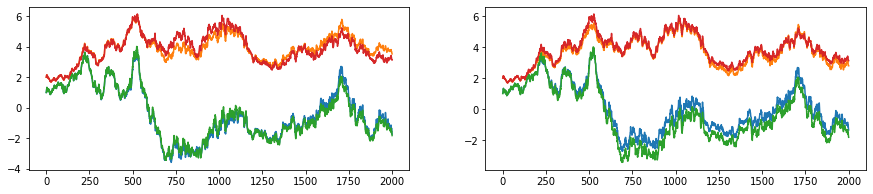

In [16]:
f,p=plt.subplots(1,2,figsize=(15,3))

y0 = model0.predict(x)
y0all = model0.predict(Res_split.X)
print(sum_square_error(y0,Res_split.Ytrain).numpy())
print(sum_square_error(y0all,Res_split.Y).numpy())
p[0].plot(model0.predict(Res_split.X))
p[0].plot(Res_split.Y)

y = model.predict(x)
yall = model.predict(Res_split.X)
print(sum_square_error(y,Res_split.Ytrain).numpy())
print(sum_square_error(yall,Res_split.Y).numpy())
p[1].plot(yall)
p[1].plot(Res_split.Y)

# model.set_weights([w0.T,b0])
# w,b = model.get_weights()
# y = model.predict(x)
# yall = model.predict(Res_split.Xdata)
# print(sum_square_error(y,Res_split.Ytrain).numpy())
# print(sum_square_error(yall,Res_split.Ydata).numpy())
# p[2].plot(yall)
# p[2].plot(Res_split.Ydata)

plt.show()

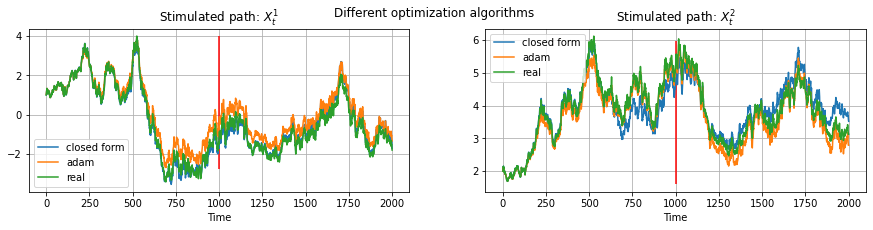

In [17]:
f,p=plt.subplots(1,2,figsize=(15,3))
for i in range(2):
    p[i].plot(model0.predict(Res_split.X)[:,i])
    p[i].plot(yall[:,i])
    p[i].plot(Res_split.Y[:,i])
    p[i].grid()
    p[i].legend([ 'closed form',  'adam' , 'real'])
    p[i].vlines(1000,yall[:,i].min()-0.1,yall[:,i].max()+0.1,'r')
    p[i].set_xlabel('Time')
p[0].title.set_text('Stimulated path: $X^{1}_{t}$')
p[1].title.set_text('Stimulated path: $X^{2}_{t}$')
plt.suptitle('Different optimization algorithms')
plt.show()

## Nonlinear try 

In [18]:
# dimR = 150
# dim = 2
# alpha = 1e-10
# inputs = keras.Input(shape=(dimR*dim))
# l = tf.keras.layers.Dense(units = dim, activation='linear',
#                          kernel_regularizer=tf.keras.regularizers.l2(alpha),
#                          bias_regularizer=tf.keras.regularizers.l2(alpha)
#                          )
# outputs = l(inputs)
# model_nonlinear = tf.keras.Model(inputs = inputs, outputs = outputs)

# model_nonlinear .compile(optimizer='adam', loss=sum_square_error, metrics = sum_square_error)
# model_nonlinear .fit(x = Res_split.Xtrain, y = Res_split.Ytrain, epochs=10000, verbose = 0, batch_size = n_sample)
# l,m = model.evaluate(x,Res_split.Ytrain,batch_size = n_sample)

## Splitting is good or not? 
### Linear SDE
For linear SDE
$$
dX_t = \sum_{k=1}^{m} B^{k}X_{t}dW^{k}_{t},\quad X_{t}\in \mathbb{R}^{n}, W_{t}\in\mathbb{R}^{m}, B^{k} \in \mathbb{R}^{n\times n}
$$
readout $W$ in 
$$
X_{t} = \langle W , Sig_{s,t} \rangle X_{s}
$$
is independent with $X_{s}$ because 
$$
W^{(i_{1},\cdots,i_{m})} = B^{i_{d}}\cdots B^{i_{1}}
$$

### SDE
However, in more general setting where
$$
dX_t = \sum_{k=1}^{m} V_{k}(X_{t})dW^{k}_{t},\quad X_{t}\in \mathbb{R}^{n}, W_{t}\in\mathbb{R}^{m}, B^{k} \in \mathbb{R}^{n\times n}
$$
The readout is dependent with $X_{s}$
$$
X_{t} = \langle W(X_{s}) , Sig_{s,t} \rangle X_{s}
$$
Explicitly
$$
W^{(i_{1},\cdots,i_{m})} = V^{i_{d}}\cdots V^{i_{1}}(X_{s})
$$
where 
$$
Vf(x) = df(x)V(x)
$$
In this case, splitting causes different starting points, which requires the readout map $W$ to depend on $X_{s}$. Therefore, we can not apppy the model even though the time series is stationary.

### Alternatives
1. Restrict to 1 path learning without splitting 
2. Considering a non-linear model 
$$
X_{t} = \langle W(X_{s}) , Sig_{s,t} \rangle X_{s}
$$
with $W$ is a linear readout map but nonlinearly depends on $X_{s}$






In [19]:
tf.keras.backend.set_floatx('float32')
# Case 1
d=2    # dimension of SDE 
dBM = 2 # dimension of BM
R=150  # dimension of Resevoir
horizon = 1.0  # time horizon: T
N_time = 2000  # time discretization
dt = horizon / N_time  # dt 
time = np.arange(N_time+1) * dt # (0, dt, ..., T)
initial_value = np.array([1.0,2.0]) # X0 of the SDE

name = 'linear'
SDE_linear = SDEmethod.SDE(horizon,initial_value,d,dBM,SDEmethod.vectorfield2dlinear,N_time) 
data = SDE_linear.path()
data_test = SDE_linear.path()

R=150  # dimension of Resevoir
depth_learn = list(range(2,9))
Res_linear = Resevoir.Resevoir_split(data, depth_learn, R)

Trial = 1
N_SAMPLE = np.array([1,2,4,5,8,10])
trainto = 1000
SUBLENGTH = trainto/N_SAMPLE
SUBLENGTH = SUBLENGTH.astype(int)
# alphas=np.logspace(-10, -8, 3)
alphas = 1e-6
validto = 100
E_linear = []
for i in range(Trial):
    for ii, sublength in enumerate(SUBLENGTH):
        print('Trial:',i+1,'  Split:',N_SAMPLE[ii])
        Res_linear.prepare_all()
        Res_linear.prepare_split(sublength, trainto)
        alphas = 1e-8
        Res_linear.train(alphas, verbose = False, fix_intercept = True)
        Res_linear.plot_all(verbose = False)
        Res_linear.prepare_test(data_test, validto)
        Res_linear.plot_test(verbose = False)
        E_linear.append(Res_linear.ERROR)

Trial: 1   Split: 1
(1, 1000, 2), (1, 1000, 300), (1, 1000, 14), (1, 1000, 30), (1, 1000, 62), (1, 1000, 126), (1, 1000, 254), (1, 1000, 510), (1, 1000, 1022), 
Trial: 1   Split: 2
(2, 500, 2), (2, 500, 300), (2, 500, 14), (2, 500, 30), (2, 500, 62), (2, 500, 126), (2, 500, 254), (2, 500, 510), (2, 500, 1022), 
Trial: 1   Split: 4
(4, 250, 2), (4, 250, 300), (4, 250, 14), (4, 250, 30), (4, 250, 62), (4, 250, 126), (4, 250, 254), (4, 250, 510), (4, 250, 1022), 
Trial: 1   Split: 5
(5, 200, 2), (5, 200, 300), (5, 200, 14), (5, 200, 30), (5, 200, 62), (5, 200, 126), (5, 200, 254), (5, 200, 510), (5, 200, 1022), 
Trial: 1   Split: 8
(8, 125, 2), (8, 125, 300), (8, 125, 14), (8, 125, 30), (8, 125, 62), (8, 125, 126), (8, 125, 254), (8, 125, 510), (8, 125, 1022), 
Trial: 1   Split: 10
(10, 100, 2), (10, 100, 300), (10, 100, 14), (10, 100, 30), (10, 100, 62), (10, 100, 126), (10, 100, 254), (10, 100, 510), (10, 100, 1022), 


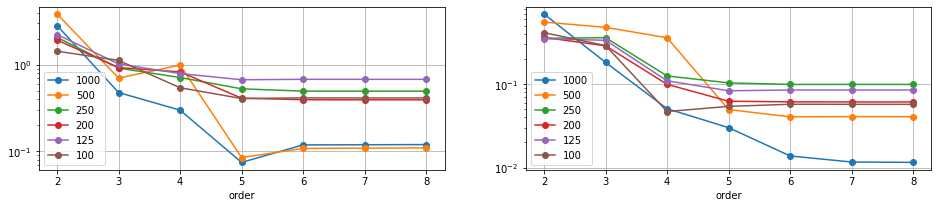

In [20]:
f,p=plt.subplots(1,2,figsize=(16,3))
for i in range(2):
    for e in E_linear:
        p[i].plot(Res_linear.depth_learn, e[:len(Res_linear.depth_learn),i],'-o')
    p[i].legend(['1000','500','250','200','125','100'])
    p[i].set_yscale('log')
    p[i].set_xlabel('order')
    p[i].grid()

In [21]:
# Case 2
d=2    # dimension of SDE 
dBM = 2 # dimension of BM
R=150  # dimension of Resevoir
horizon = 1.0  # time horizon: T
N_time = 2000  # time discretization
dt = horizon / N_time  # dt 
time = np.arange(N_time+1) * dt # (0, dt, ..., T)
initial_value = np.array([1.0,2.0]) # X0 of the SDE

name = 'sabr'
SDE_sabr = SDEmethod.SDE(horizon,initial_value,d,dBM,SDEmethod.vectorfield2d,N_time) 
data = SDE_sabr.path()
data_test = SDE_sabr.path()

R=150  # dimension of Resevoir
depth_learn = list(range(2,9))
Res_sabr = Resevoir.Resevoir_split(data, depth_learn, R)

Trial = 1
N_SAMPLE = np.array([1,2,4,5,8,10])
trainto = 1000
SUBLENGTH = trainto/N_SAMPLE
SUBLENGTH = SUBLENGTH.astype(int)
# alphas=np.logspace(-10, -8, 3)
alphas = 1e-6
validto = 100
E_sabr = []
for i in range(Trial):
    for ii, sublength in enumerate(SUBLENGTH):
        print('Trial:',i+1,'  Split:',N_SAMPLE[ii])
        Res_sabr.prepare_all()
        Res_sabr.prepare_split(sublength, trainto)
        alphas = 1e-8
        Res_sabr.train(alphas, verbose = False, fix_intercept = True)
        Res_sabr.plot_all(verbose = False)
        Res_sabr.prepare_test(data_test, validto)
        Res_sabr.plot_test(verbose = False)
        E_sabr.append(Res_sabr.ERROR)

Trial: 1   Split: 1
(1, 1000, 2), (1, 1000, 300), (1, 1000, 14), (1, 1000, 30), (1, 1000, 62), (1, 1000, 126), (1, 1000, 254), (1, 1000, 510), (1, 1000, 1022), 
Trial: 1   Split: 2
(2, 500, 2), (2, 500, 300), (2, 500, 14), (2, 500, 30), (2, 500, 62), (2, 500, 126), (2, 500, 254), (2, 500, 510), (2, 500, 1022), 
Trial: 1   Split: 4
(4, 250, 2), (4, 250, 300), (4, 250, 14), (4, 250, 30), (4, 250, 62), (4, 250, 126), (4, 250, 254), (4, 250, 510), (4, 250, 1022), 
Trial: 1   Split: 5
(5, 200, 2), (5, 200, 300), (5, 200, 14), (5, 200, 30), (5, 200, 62), (5, 200, 126), (5, 200, 254), (5, 200, 510), (5, 200, 1022), 
Trial: 1   Split: 8
(8, 125, 2), (8, 125, 300), (8, 125, 14), (8, 125, 30), (8, 125, 62), (8, 125, 126), (8, 125, 254), (8, 125, 510), (8, 125, 1022), 
Trial: 1   Split: 10
(10, 100, 2), (10, 100, 300), (10, 100, 14), (10, 100, 30), (10, 100, 62), (10, 100, 126), (10, 100, 254), (10, 100, 510), (10, 100, 1022), 


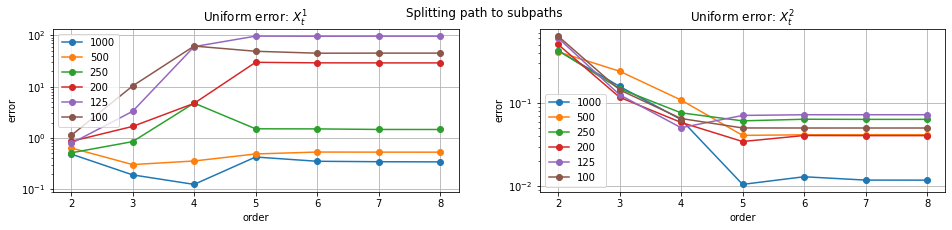

In [22]:
f,p=plt.subplots(1,2,figsize=(16,3))
for i in range(2):
    for e in E_sabr:
        p[i].plot(Res_sabr.depth_learn, e[:len(Res_sabr.depth_learn),i],'-o')
    p[i].legend(['1000','500','250','200','125','100'])
    p[i].set_yscale('log')
    p[i].set_xlabel('order')
    p[i].set_ylabel('error')
    p[i].grid()
p[0].title.set_text('Uniform error: $X^{1}_{t}$')
p[1].title.set_text('Uniform error: $X^{2}_{t}$')
plt.suptitle('Splitting path to subpaths')
plt.show()

# Generative model 

In [23]:
# import tensorflow as tf
# import gpflow
# from tqdm.auto import tqdm
# from gpsig import kernels
# import evaluation
# import process_discriminator
# tf.keras.backend.set_floatx('float64')

## Signature MMD 

In [24]:
# d=2
# M=150
# n_samples = 100
# name = 'sabr'
# SDE_sabr = Resevoir.SDE(horizon,initial_value,d,2,M,Resevoir.vectorfield2d,50)
# SDE_linear = Resevoir.SDE(horizon,initial_value,d,2,M,Resevoir.vectorfield2dlinear,50)
# SDE_simple = Resevoir.SDE(horizon,initial_value,d,2,M,Resevoir.vectorfield2dsimple,50)


# X = tf.constant([np.array(SDE_sabr.path()[-1]) for i in range(n_samples)])
# Y = tf.constant([np.array(SDE_linear.path()[-1]) for i in range(n_samples)])
# f,p=plt.subplots(1,2,figsize=(16,4))
# for i in range(2):
#     [p[i].plot(x[:,i],'b', alpha = 0.1) for x in X]
#     [p[i].plot(x[:,i],'r', alpha = 0.1) for x in Y]
# plt.show()

In [25]:
# num_levels = 3
# num_lags = 0
# kernE = kernels.SignatureKernel(base_kernel = gpflow.kernels.Exponential(), \
#                                 num_levels = num_levels, order = num_levels, num_lags = num_lags)

In [26]:
# TU00 = []
# TU11 = []
# for i in tqdm(range(10)):
#     X = tf.constant([np.array(SDE_sabr.path()[-1]) for i in range(n_samples)])
#     Y = tf.constant([np.array(SDE_simple.path()[-1]) for i in range(n_samples)])
#     Z = tf.constant([np.array(SDE_sabr.path()[-1]) for i in range(n_samples)])
#     TU00.append(evaluation.Sig_TU2(X,Z,kernE))
#     TU11.append(evaluation.Sig_TU2(X,Y,kernE))
# plt.hist(TU00)
# plt.hist(TU11)
# plt.show()

In [27]:
# TU0 = []
# TU1 = []
# for i in tqdm(range(10)):
#     X = tf.constant([np.array(SDE_sabr.path()[-1]) for i in range(n_samples)])
#     Y = tf.constant([np.array(SDE_linear.path()[-1]) for i in range(n_samples)])
#     Z = tf.constant([np.array(SDE_sabr.path()[-1]) for i in range(n_samples)])
#     TU0.append(evaluation.Sig_TU2(X,Z,kernE))
#     TU1.append(evaluation.Sig_TU2(X,Y,kernE))

In [28]:
# plt.hist(TU0,alpha = 0.5)
# plt.hist(TU1,alpha = 0.5)
# plt.show()

# Random Projection

In [29]:
# BM_dim = 3
# depth = 5
# eqq = SDEmethod.SDE_new(horizon,1.0,dimension,BM_dim,length,B)
# BMpath_sig = eqq.BM()
# sig_path_stream = Sig_method.sig_stream2(np.array(BMpath_sig),depth)[0,:,:].numpy()
# sigdim = sig_path_stream.shape[-1]

# Vec = np.array(Sig_method.sig_vectorfield(BM_dim, depth))
# sig_dim = Vec.shape[-1]
# initial_sig = np.zeros(sig_dim)
# initial_sig[0] = 1
# eq2 = SDEmethod.SDE_new(horizon,1.0,sig_dim,BM_dim,length,Vec)
# SDEpath_sig = eq2.SDE_solver(initial_sig, BMpath_sig, 'euler')
# np.linalg.norm(SDEpath_sig - sig_path_stream,np.inf)  

In [30]:
# import random_projection
# rp = random_projection.check_rp(sig_path_stream)
# rp_matrix = rp.fit_transform(np.eye(sigdim)).T
# almost_id = rp_matrix.T@rp_matrix

# History

In [31]:
# 'Sabr'
# B[0,0,1] = 2
# B[0,1,1] = 1
# B[1,0,1] = 2
# B[1,1,1] = 0

#     def reservoir(self,BMpath):
#         reservoirpath = np.zeros(shape = [self.batch, self.timesteps+1, self.dimensionR])
#         reservoirpath[:,0,0] = np.ones(self.batch)
#         for i in range(self.timesteps):
#             increment = BMpath[:,i+1,:] - BMpath[:,i,:]
#             reservoirpath[:,i+1,:] = reservoirpath[:,i,:] + self.reservoirfield(SDEpath[:,i,:],increment)
#         self.reservoirpath  = reservoirpath   
#         return reservoirpath    
    
#     def analytic_SDE(self,BMpath):
#         a = np.tensordot(BMpath,B,axes = [-1,0])
#         a = np.sum(a,axis = (-1))
#         b = 0.5 * self.time[:,None] * np.sum(B**2,axis = (0,1))
#         b = b[None,:,:]
#         return np.exp(a-b)
#     def vectorfield_linear(state,increment):
#         V = np.tensordot(B,state,axes = [2,1]).T
#         dX = V@increment[:,:,None]
#         return dX[:,:,0]
#     def euler(self,BMpath):
#         SDEpath = np.zeros(shape = [self.batch, self.timesteps+1, self.dimension])
#         SDEpath[:,0,:] = np.ones([self.batch,self.dimension])
#         for i in range(self.timesteps):
#             increment = BMpath[:,i+1,:] - BMpath[:,i,:]
#             SDEpath[:,i+1,:] = SDEpath[:,i,:] + self.vectorfield(SDEpath[:,i,:],increment)
#         return SDEpath

# def sig_stream1(path,depth):                 # Unified depth 
#     path = torch.Tensor(path[None,:,:])
#     batch, length, channels = path.shape
#     length = length-1
#     index2word = index_to_word(channels, depth)
#     dim_sig = len(index2word)+1
#     sig_path_split = [signatory.signature(path[:,i:i+2,:], depth) for i in range(length)] 
#     add = sig_path_split[0]
#     sig_path_stream = [add[:,None,:]]
#     for i in range(len(sig_path_split)-1):
#         add = signatory.signature_combine(add, sig_path_split[i+1], channels, depth)
#         sig_path_stream.append(add[:,None,:])
#     sig_path_stream = torch.cat(sig_path_stream,axis = 1)
#     sig_path_stream = torch.cat([torch.zeros([batch,1,dim_sig-1]),sig_path_stream],axis = 1)
#     sig_path_stream = torch.cat([torch.ones([batch,length+1,1]),sig_path_stream],axis = 2)
#     return sig_path_stream

# def sig_stream2(path,depth_max):          # growing signature with only discrete approximation
#     path = torch.Tensor(path[None,:,:])
#     batch, length, channels = path.shape
#     length = length-1
#     index2word = index_to_word(channels, depth_max)
#     dim_sig = len(index2word)+1
#     sig_path_split = [signatory.signature(path[:,i:i+2,:], 1) for i in range(length)] 
#     sig_path = sig_path_split[0]
#     dim_0 = signatory.signature_channels(channels,depth_max) - signatory.signature_channels(channels,1)
#     helper0 = torch.zeros(size = [1,dim_0])
#     sig_path_aug = torch.cat([sig_path,helper0],axis = -1)
#     sig_path_stream = [sig_path_aug[:,None,:]]
#     for i in range(len(sig_path_split)-1):
#         depth_now = min(i + 2,depth_max)
#         depth_pre = min(i + 1,depth_max)
#         dim_0 = signatory.signature_channels(channels,depth_max) - signatory.signature_channels(channels,depth_now)
#         dim_1 = signatory.signature_channels(channels,depth_now) - signatory.signature_channels(channels,depth_pre)
#         dim_2 = signatory.signature_channels(channels,depth_now) - signatory.signature_channels(channels,1)
#         helper0 = torch.zeros(size = [1,dim_0])
#         helper1 = torch.zeros(size = [1,dim_1])
#         helper2 = torch.zeros(size = [1,dim_2])

#         sig1 = torch.cat([sig_path,helper1],axis = -1)
#         sig2 = torch.cat([sig_path_split[i+1],helper2],axis = -1)
#         sig_path = signatory.signature_combine(sig1, sig2, channels, depth_now)
#         sig_path_aug = torch.cat([sig_path,helper0],axis = -1)
#         sig_path_stream.append(sig_path_aug[:,None,:])

#     sig_path_stream = torch.cat(sig_path_stream,axis = 1)
#     sig_path_stream = torch.cat([torch.zeros([batch,1,dim_sig-1]),sig_path_stream],axis = 1)
#     sig_path_stream = torch.cat([torch.ones([batch,length+1,1]),sig_path_stream],axis = 2)
#     return sig_path_stream

# def sig_vectorfield(channels, depth):
#     index2word = index_to_word(channels, depth)
#     word2index = word_to_index(channels, depth)
#     dim_sig = len(index2word)+1
#     V = [np.zeros([dim_sig, dim_sig]) for i in range(channels)]
#     for i in range(dim_sig):
#         if i > 0:
#             res = (i-1)%channels
#             word = index2word[i-1]
#             if len(word) == 1:
#                 V[res][i,0] = 1
#             else:
#                 word_reduce = tuple(list(word)[:-1])
#                 V[res][i,word2index[word_reduce]+1] = 1
#     return V

# plt.figure(figsize = (15,5))
# plt.plot(time,SDEpath)
# plt.plot(time,SDEpath1)
# plt.plot(time,SDEpath2)
# plt.legend(['analytic 1','analytic 2','euler 1','euler 2', 'milstein 1','milstein 2'])




In [32]:
# def sigBM(path):                  ### exact for (0,0) (1,1)
#     batch = path.shape[0]
#     channels = path.shape[-1]
#     diff = path[:,1,:] - path[:,0,:]
#     opt = torch.zeros([batch,6])
#     opt[:,0:2] = diff
#     opt[:,2] = (diff[:,0]**2 - dt)/2
#     opt[:,3] = (diff[:,0]*diff[:,1])/2
#     opt[:,4] = (diff[:,0]*diff[:,1])/2
#     opt[:,5] = (diff[:,1]**2 - dt)/2
#     return opt

# def sig_stream3(path,depth_max):          # growing signature only for BM 
#     path = torch.Tensor(path[None,:,:])
#     batch, length, channels = path.shape
#     length = length-1
#     index2word = index_to_word(channels, depth_max)
#     dim_sig = len(index2word)+1
#     print(dim_sig)
#     sig_path_split = [sigBM(path[:,i:i+2,:]) for i in range(length)] 
#     sig_path = sig_path_split[0]
#     dim_0 = signatory.signature_channels(channels,depth_max) - signatory.signature_channels(channels,2)
#     helper0 = torch.zeros(size = [1,dim_0])
#     sig_path_aug = torch.cat([sig_path,helper0],axis = -1)
#     sig_path_stream = [sig_path_aug[:,None,:]]
#     for i in range(len(sig_path_split)-1):
#         depth_now = min(2*(i+2),depth_max)
#         depth_pre = min(2*(i+1),depth_max)
#         dim_0 = signatory.signature_channels(channels,depth_max) - signatory.signature_channels(channels,depth_now)
#         dim_1 = signatory.signature_channels(channels,depth_now) - signatory.signature_channels(channels,depth_pre)
#         dim_2 = signatory.signature_channels(channels,depth_now) - signatory.signature_channels(channels,2)
#         helper0 = torch.zeros(size = [1,dim_0])
#         helper1 = torch.zeros(size = [1,dim_1])
#         helper2 = torch.zeros(size = [1,dim_2])

#         sig1 = torch.cat([sig_path,helper1],axis = -1)
#         sig2 = torch.cat([sig_path_split[i+1],helper2],axis = -1)
#         sig_path = signatory.signature_combine(sig1, sig2, channels, depth_now)
#         sig_path_aug = torch.cat([sig_path,helper0],axis = -1)
#         sig_path_stream.append(sig_path_aug[:,None,:])

#     sig_path_stream = torch.cat(sig_path_stream,axis = 1)
#     sig_path_stream = torch.cat([torch.zeros([batch,1,dim_sig-1]),sig_path_stream],axis = 1)
#     sig_path_stream = torch.cat([torch.ones([batch,length+1,1]),sig_path_stream],axis = 2)
#     return sig_path_stream

In [33]:
# def sig_vectorfield(channels, depth):
#     index2word = index_to_word(channels, depth)
#     word2index = word_to_index(channels, depth)
#     dim_sig = len(index2word)+1
#     V = [np.zeros([dim_sig, dim_sig]) for i in range(channels)]
#     for i in range(dim_sig):
#         if i > 0:
#             res = (i-1)%channels
#             word = index2word[i-1]
#             if len(word) == 1:
#                 V[res][i,0] = 1
#             else:
#                 word_reduce = tuple(list(word)[:-1])
#                 V[res][i,word2index[word_reduce]+1] = 1
#     return V

# def semi_group_sig(state,increment,dt):
#     dimension = state.shape[-1]
#     I = np.eye(dimension)
#     a = np.tensordot(increment,Vec,axes = 1)
#     V = I + a
#     dX = V@state
#     return dX

# sig_path_stream = sig_stream2(BMpath,10)[0,:,:].numpy()

# Vec = np.array(sig_vectorfield(dimensionBM, 10))
# sig_dim = Vec.shape[-1]
# initial_sig = np.zeros(sig_dim)
# initial_sig[0] = 1

# SDEpath_sig = np.zeros(shape = [length+1, sig_dim])
# SDEpath_sig[0,:] = initial_sig
# for i in range(length):
#     increment = BMpath[i+1,:] - BMpath[i,:]
#     SDEpath_sig[i+1,:] = semi_group_sig(SDEpath_sig[i,:],increment,1)
    
# np.linalg.norm(SDEpath_sig - sig_path_stream,np.inf)    

In [34]:
# def helperfunc(X,depth):
#     BB = B_aug(B,depth)
#     CC = np.array([M @ initial for M in BB])
#     SDEpath_by_signature = np.dot(X,CC)
#     return SDEpath_by_signature
# f,p=plt.subplots(1,2,figsize=(16,4))
# for i in range(2):
#     p[i].plot(helperfunc(Xdata[:2000],depth_learn)[:,i])
#     p[i].plot(Ydata[:2000][:,i])
# plt.savefig('training.pdf')
# plt.show()

In [35]:
# EE = []
# validto = 100
# depth_learn = list(range(2,9))
# Trial = 10
# N_SAMPLE = np.array([1,2,4,5,8,10])
# trainto = 1000
# SUBLENGTH = trainto/N_SAMPLE
# SUBLENGTH = SUBLENGTH.astype(int)
# alphas=np.logspace(-10, -8, 3)

# for i in range(Trial):
#     print(i)
#     Res_split.valid_split(validto, depth_learn)
#     for sublength in SUBLENGTH:
#         Res_split.prepare(depth_learn)
#         Res_split.prepare_split(depth_learn,sublength,trainto)
#         Res_split.train_split(alphas)
#         Res_split.plot_train_split()
#         Res_split.plot_valid_split(validto)
#         EE.append(Res_split.ERROR_valid)
        
        
# f,p=plt.subplots(10,1,figsize=(10,40))
# color = ['b','g','r','c','y','k']
# for it in range(6):
#     E = EE[it::6] 
#     for i,e in enumerate(E):
#         p[i].plot(Res_split.depth_learn, e[:len(Res_split.depth_learn)],color[it]+'-o')
#         p[i].legend(['1000','500','250','200','125','100'])
#         p[i].set_yscale('log')
# plt.show()

In [36]:
# reload(Resevoir)
# d=2    # dimension of SDE 
# dBM = 2 # dimension of BM
# M=150  # dimension of Resevoir
# horizon = 1.0  # time horizon: T
# N_time = 2000  # time discretization
# dt = horizon / N_time  # dt 
# time = np.arange(N_time+1) * dt # (0, dt, ..., T)
# initial_value = np.array([1.0,2.0]) # X0 of the SDE

# # name = 'linear'
# # SDE = Resevoir.SDE(horizon,initial_value,d,dBM,M,Resevoir.vectorfield2dlinear,N_time) 
# name = 'sabr' # define the dynamic (vector field) of SDE
# SDE = Resevoir.SDE(horizon,initial_value,d,dBM,M,Resevoir.vectorfield2d,N_time) 
# training = SDE.path()
# BMpath = np.array(training[0])
# SDEpath = np.array(training[1])

# f1,p1=plt.subplots(1,2,figsize=(16,3))
# p1[0].plot(BMpath)
# p1[0].set_title('BMpath')
# p1[1].plot(SDEpath)
# p1[1].set_title('SDEpath')
# plt.savefig(name + '/1.png')
# plt.show()

# Res_split = Resevoir.Resevoir_split(SDE, training)
# trainto = 1000
# sublength = 1000
# depth_learn = list(range(2,9))
# Res_split.prepare(depth_learn)
# Res_split.prepare_split(depth_learn,sublength,trainto)

# # alphas=np.logspace(-10, -8, 3)
# alphas = 1e-6
# Res_split.train_split(alphas, verbose = False, fix_intercept = True)
# Res_split.plot_train_split(verbose = False)

# validto = 500
# Res_split.valid_split(validto, depth_learn)
# Res_split.plot_valid_split(validto, verbose = False)